# Machine Learning Coursework - Logistic Regression & Random Forests

Edward Atkins & Nicholas Johnston

### Motivation
* Motivated to determine superior machine learning algorithm, Logistic Regression or Random Forest for binary classification.
* Experiment will be run using the ‘adult’ dataset, taken from UCI archive. Dataset contains 12 independent variables extracted from the 1994 US census data. E.g. Occupation, Gender, Marital Status and Education.
* Dependant Variable – Income. Aim to produce two models capable of classifying individuals annual salary as being  above or below $50,000.
* Superior model will achieve a higher average score across several metrics. 

### Hypothesis
A Random Forest model will outperform a Logistic Regression model for binary classification on the ‘adult’ dataset (Caruana, 2006)


### Imports

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
import seaborn
from sklearn.metrics import precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.patches as mpatches
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### DATA PREPARATION & TRANSFORMATION

In [2]:
### Read in the data set ###
df = pd.read_csv('adult.csv',header=None)

### Set the headers on the dataset ###
df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income_indicator'] 

#### Helper functions to create dataframe of indepdent variables and add dummy variables where neccessary ###

def add_X_variables_categorical(source_df,X,variables):
    for variable in variables:
        dummies = pd.get_dummies(source_df[variable],prefix=variable)
        X = X.join(dummies.ix[:,1:])
    return X

def add_X_variables_real(source_df,X,variables):
    '''Also binary'''
    for variable in variables:
        X = X.join(source_df[variable])
    return X

### Create empty dataframes for independent and dependent variables ###
Y = pd.DataFrame(index=df.index)
X = pd.DataFrame(index=df.index)

### Add dependent variable to dataframe ###
Y = add_X_variables_categorical(df,Y,['income_indicator'])
Y = Y['income_indicator_ >50K']

### Add independent variables to dataframe ###
categorical_variables = ['workclass','marital-status','occupation','relationship','race','sex','native-country']
real_variables = ['age','education-num','capital-gain','capital-loss','hours-per-week']
X = add_X_variables_categorical(df,X,categorical_variables)
X = add_X_variables_real(df,X,real_variables)

### PRELIMINARY DATA ANALYSIS & VISUALISATION INC. FEATURE SCALING

* Number of Data set examples: 32,561
* Number of features: 12
* 75.5% of the population had an income lower than 50,000 dollars.
* The histograms depicted below show the splits that can be observed between high and low income earners against different independent variables. E.g. High correlation between earning > $50,000 and a greater level of education.

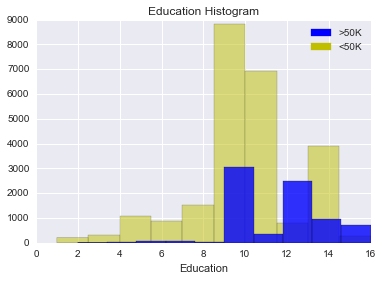

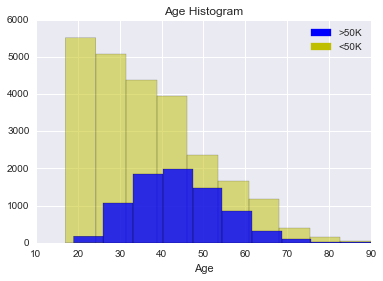

For Component 1:
Column marital-status_ Married-civ-spouse has a PCA value of 0.6282641975332347
Column marital-status_ Never-married has a PCA value of -0.4985937169874945
Column sex_ Male has a PCA value of 0.35726311499516444
Column relationship_ Not-in-family has a PCA value of -0.3057989276424166
Column relationship_ Own-child has a PCA value of -0.21462676686431775
Column workclass_ Private has a PCA value of -0.1256402484725192
Column age has a PCA value of 0.10852318222034386
Column occupation_ Adm-clerical has a PCA value of -0.09434227349297024
Column occupation_ Other-service has a PCA value of -0.091129775272835
Column occupation_ Craft-repair has a PCA value of 0.08685223343707951


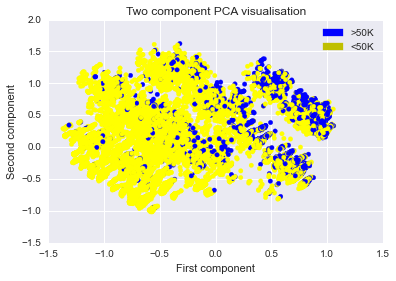

In [3]:
### Plot histograms of education and age separated by income ###
education_1 = list(X['education-num'][Y == 1])
education_2 = list(X['education-num'][Y == 0])

blue_patch = mpatches.Patch(color='b', label='>50K')
yellow_patch = mpatches.Patch(color='y', label='<50K')

plt.hist(education_2,color='y',alpha=0.5)
plt.hist(education_1,color='b',alpha=0.8)
plt.xlabel('Education')
plt.legend(handles=[blue_patch,yellow_patch])
plt.title('Education Histogram')
plt.show()

age_1 = list(X['age'][Y == 1])
age_2 = list(X['age'][Y == 0])

plt.hist(age_2,color='y',alpha=0.5)
plt.hist(age_1,color='b',alpha=0.8)
plt.xlabel('Age')
plt.legend(handles=[blue_patch,yellow_patch])
plt.title('Age Histogram')
plt.show()


### Feature scaling to a common range [0,1] ###
for column in X.columns:
    X[column] = (X[column] - X[column].min())     /(X[column].max() - X[column].min())


### PCA vizualisation and examination of most dominant features one one-axis ###
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
x_matrix = X.as_matrix()
transform = pca.fit_transform(X)

components = pca.components_
y_components = components[0]
top10_values = np.asarray(y_components)[np.argsort(np.abs(y_components))[::-1]][0:10]
top10_name = np.asarray(X.columns)[np.argsort(np.abs(y_components))[::-1]][0:10]

print("For Component 1:")
for i in range(0,10):
    print("Column {} has a PCA value of {}".format(top10_name[i],top10_values[i]))


x_transformed = [x[0] for x in transform]
y_transformed = [y[1] for y in transform]

y_list = list(Y)
colors = []
for y in y_list:
    if y == 1:
        colors.append('blue')
    else:
        colors.append('yellow')

plt.scatter(x_transformed, y_transformed,color=colors)
plt.legend(handles=[blue_patch,yellow_patch])
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Two component PCA visualisation')
plt.show()

### MISCELLANEOUS 

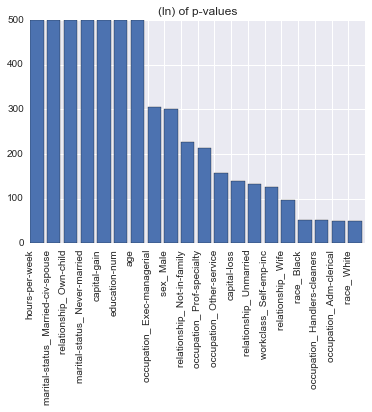

All zeros accuracy: 0.7559103469450414


In [6]:
### Split the datset into training and test set ###
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=45)


### Identify best predictors using SelectKBest on the training dataset ###
selector = SelectKBest(f_classif, k=10)
selector.fit(X_train, Y_train.as_matrix())

# Get the raw p-values for each feature, take natural log to transform to useable number
scores = -np.log10(selector.pvalues_)
columns = list(X.columns)

# Create dataframe in order to find top 10 predictors
df1 = pd.DataFrame(list(zip(columns,scores)), columns = ['variable','score'])
df1 = df1.sort_index(by='score', ascending = False)
df1 = df1.replace([np.inf], 500)
df1 = df1.dropna()
y = df1.score[0:20]
x = df1.variable[0:20]

x = np.asarray(x)
y = np.asarray(y)

# Plot the top ten scores - Identify strong prediction variables
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x, rotation='vertical')
plt.title('(ln) of p-values')
plt.show()

### All zeros - i.e. what is the expected accuracy for a model that predicts all zeros ###
correct = 0
incorrect = 0
all_zeros = [0] * len(Y_test.as_matrix())

accuracy = sum(all_zeros == Y_test.as_matrix()) / len(all_zeros)
print("All zeros accuracy: {}".format(accuracy))

### LOGISTIC REGRESSION MODEL

In [7]:
#Define parameters for hyper-parameter tuning
parameters = {'penalty':['l1','l2']}

#Create model
logistic = LogisticRegression(random_state=2)

# Grid search used to find best model in hyper-paramater space
logistic_model = GridSearchCV(logistic,parameters)
logistic_model.fit(X_train,Y_train)
print(logistic_model.best_estimator_)

# Make predictions on test set
predictions = logistic_model.predict(X_test)

# Get accuracy measure
accuracy = sum(predictions == Y_test.as_matrix()) / len(predictions)
print("Logistic Regression accuracy: {}".format(accuracy))

# Get grid scores for hyper-parameter tuning
logistic_grid_scores = logistic_model.grid_scores_


### Evaluation metrics for logistic Regression ###
TP = sum(((predictions == 1) & (Y_test.as_matrix() == 1)))
FP = sum(((predictions == 1) & (Y_test.as_matrix() == 0)))
TN = sum(((predictions == 0) & (Y_test.as_matrix() == 0)))
FN = sum(((predictions == 0) & (Y_test.as_matrix() == 1)))

print('True Positives: {0}, False Positives: {1}, True Negatives: {2}, False Negatives: {3}'.format(TP,FP,TN,FN))

decimal_preds = logistic_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_test, decimal_preds)
log_fpr = fpr
log_tpr = tpr
precision, recall, _ = precision_recall_curve(Y_test, decimal_preds)
log_precision = precision
log_recall = recall
LRprecision = TP /(TP + FP)
LRrecall = TP / (TP + FN)
F1 = 2 * ((LRprecision * LRrecall) / (LRprecision + LRrecall))
print('F1 score for Logistic Regression: {0}'.format(F1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0)
Logistic Regression accuracy: 0.854467301197421
True Positives: 491, False Positives: 170, True Negatives: 2292, False Negatives: 304
F1 score for Logistic Regression: 0.6744505494505495


### RANDOM FOREST MODEL

In [8]:
# Define parameters for hyper-parameter tuning
parameters = {'max_depth':[1,3,10,30,None],'min_samples_split':[1,3,10,30],'min_samples_leaf':[1,3,10,30,100]}

# Create model
forest = RandomForestClassifier(n_estimators=10, random_state=2)

# Grid search used to find best model in hyper-paramater space
forest_model = GridSearchCV(forest, parameters)
forest_model.fit(X_train,Y_train)
print(forest_model.best_estimator_)

#Predict on test set
forest_predictions = forest_model.predict(X_test)

#Get accuracy measure
accuracy = sum(forest_predictions == Y_test.as_matrix()) / len(forest_predictions)

print("Random Forest accuracy: {}".format(accuracy))

#Get scores for grid search
grid_scores = forest_model.grid_scores_
accuracies = [x[1] for x in grid_scores]

log_accuracies = [x[1] for x in logistic_grid_scores]

# Random Forest metrics
TP = sum(((forest_predictions == 1) & (Y_test.as_matrix() == 1)))
FP = sum(((forest_predictions == 1) & (Y_test.as_matrix() == 0)))
TN = sum(((forest_predictions == 0) & (Y_test.as_matrix() == 0)))
FN = sum(((forest_predictions == 0) & (Y_test.as_matrix() == 1)))

print('True Positives: {0}, False Positives: {1}, True Negatives: {2}, False Negatives: {3}'.format(TP,FP,TN,FN))

decimal_preds = forest_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(Y_test, decimal_preds)
forest_precision, forest_recall, _ = precision_recall_curve(Y_test, decimal_preds)
RFprecision = TP /(TP + FP)
RFrecall = TP / (TP + FN)
F1 = 2 * ((RFprecision * RFrecall) / (RFprecision + RFrecall))
print('F1 score for Random Forest: {0}'.format(F1))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)
Random Forest accuracy: 0.868590727663494
True Positives: 497, False Positives: 130, True Negatives: 2332, False Negatives: 298
F1 score for Random Forest: 0.69901547116737


### FINAL RESULTS VISUALISATION & ANALYSIS

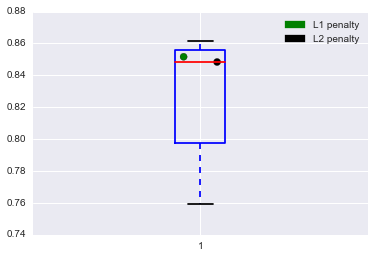

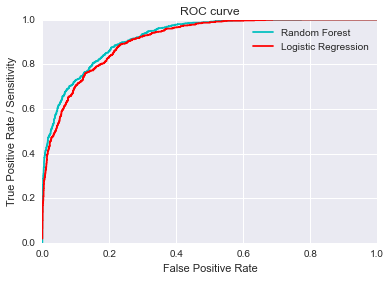

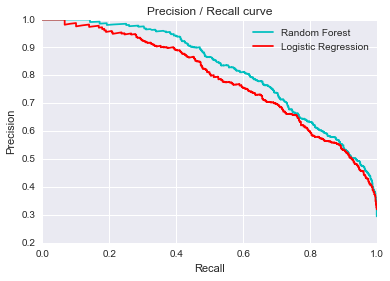

Area under the curve for LogisticRegression = 0.7855004956801339
Area under the curve for Random Forest = 0.8184759532972001


In [9]:
### Boxplot of hyper-parameter tuning mean accuracies ###
plt.scatter([0.95,1.05],[log_accuracies],s=50,c=['g','k'],alpha=1)
green_patch = mpatches.Patch(color='g', label='L1 penalty')
black_patch = mpatches.Patch(color='k', label='L2 penalty')
plt.legend(handles=[green_patch,black_patch])
plt.boxplot(accuracies)
plt.show()


### Plotting of ROC Curves for both Random Forest & Logistic Regression ###
plt.plot(fpr, tpr, 'c-', label = 'Random Forest')
plt.plot(log_fpr,log_tpr,'r-', label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Sensitivity')
plt.title('ROC curve')
plt.legend(loc = 'best')
plt.show()

plt.plot(forest_recall, forest_precision, 'c-', label = 'Random Forest')
plt.plot(log_recall, log_precision, 'r-', label = 'Logistic Regression')


### Plotting of Precision Recall Curve for both Random Forest & Logistic Regression ###
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision / Recall curve')
plt.legend(loc = 'best')
plt.show()

### AUC (Area Under Curve) for both models ###
auc1 = metrics.auc(log_recall,log_precision)
print('Area under the curve for LogisticRegression = {0}'.format(auc1))

auc2 = metrics.auc(forest_recall,forest_precision)
print('Area under the curve for Random Forest = {0}'.format(auc2))

* As expected from literature research the Random Forest algorithm outperforms Logistic Regression across all four of our chosen metrics.
* A critical differentiator between results was the increased ability of the Random Forest to reduce false positive predictions. 
* Both models achieve a desirable ROC curve. It is difficult to distinguish between the effectiveness of the two models. Confirmed by Area under the curve (AUC), 1% difference. 
* The Precision Recall curve is useful in highlighting differences between algorithms trained on datasets which predict a greater amount of negative outcomes, (Davis & Goadrich 2006). In contrast to our ROC curves we can see a clear separation in algorithm performance, Random Forest the clear winner. This visual confirmation is further emphasised by a 3% difference in the AUC score.
* F1 score achieved by Random Forest indicates an improved maximisation of both precision and recall.
